# 07 Stress Analysis

应力时程深度分析，包括 von Mises 应力和峰值应力。

In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt

from utils.data_loader import load_dataset, get_time_array
from utils.visualizer import plot_time_history, plot_stress_distribution
from utils.config import DATASET_PATH, DT

## 加载数据集

In [2]:
# 加载数据集
data = load_dataset(DATASET_PATH, normalize=False)

print("=" * 50)
print("数据集信息")
print("=" * 50)
print(f"应力数据形状: {data['stress'].shape}")
print(f"样本数: {data['stress'].shape[0]}")
print(f"时间步数: {data['stress'].shape[1]}")
print(f"单元数: {data['stress'].shape[2]}")

数据集信息
应力数据形状: (20000, 201, 11)
样本数: 20000
时间步数: 201
单元数: 11


## 选择样本和关键单元

In [3]:
# 随机选择一个样本
np.random.seed(123)
sample_idx = np.random.randint(0, data['stress'].shape[0])

# 选择几个关键单元
num_elements = data['stress'].shape[2]
key_elements = [0, num_elements//4, num_elements//2, 3*num_elements//4, num_elements-1]

print(f"选择样本: {sample_idx}")
print(f"关键单元: {key_elements}")

# 生成时间数组
t = get_time_array(data['stress'].shape[1], DT)

选择样本: 19966
关键单元: [0, 2, 5, 8, 10]


## 绘制关键单元应力时程

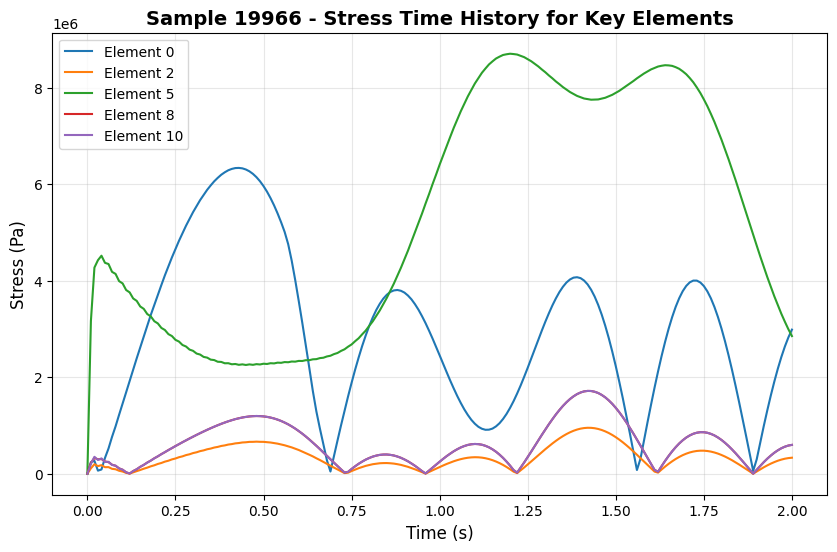

In [4]:
# 绘制关键单元的应力时程
stress_data = []
labels = []

for elem_id in key_elements:
    stress_data.append(data['stress'][sample_idx, :, elem_id])
    labels.append(f'Element {elem_id}')

plot_time_history(
    t, stress_data, labels,
    ylabel='Stress (Pa)',
    title=f'Sample {sample_idx} - Stress Time History for Key Elements'
)

## 峰值应力分析

In [5]:
# 计算每个单元的峰值应力和对应时刻
peak_stresses = np.max(np.abs(data['stress'][sample_idx]), axis=0)
peak_times = np.argmax(np.abs(data['stress'][sample_idx]), axis=0) * DT

# 找到峰值应力最大的单元
max_stress_elem = np.argmax(peak_stresses)
max_stress_value = peak_stresses[max_stress_elem]
max_stress_time = peak_times[max_stress_elem]

print("=" * 50)
print("峰值应力分析")
print("=" * 50)
print(f"最大峰值应力单元: Element {max_stress_elem}")
print(f"最大峰值应力值: {max_stress_value:.4f} Pa")
print(f"峰值应力时刻: {max_stress_time:.4f} s")

# 显示前10个最大峰值应力的单元
top_n = 10
top_elements = np.argsort(peak_stresses)[-top_n:][::-1]

print(f"\n前{top_n}个最大峰值应力单元:")
print("-" * 40)
print(f"{'Element ID':<12} {'Peak Stress (Pa)':<20} {'Peak Time (s)':<15}")
print("-" * 40)
for elem_id in top_elements:
    print(f"{elem_id:<12} {peak_stresses[elem_id]:<20.4f} {peak_times[elem_id]:<15.4f}")

峰值应力分析
最大峰值应力单元: Element 5
最大峰值应力值: 8704641.9248 Pa
峰值应力时刻: 1.2000 s

前10个最大峰值应力单元:
----------------------------------------
Element ID   Peak Stress (Pa)     Peak Time (s)  
----------------------------------------
5            8704641.9248         1.2000         
0            6338038.6409         0.4300         
3            4915489.6739         1.3800         
1            4210400.5081         1.4200         
4            1903509.8047         1.4200         
6            1716791.7159         1.4200         
10           1716139.3496         1.4200         
7            1716017.7250         1.4200         
9            1715879.5280         1.4200         
8            1715730.2322         1.4200         


## 峰值应力分布图

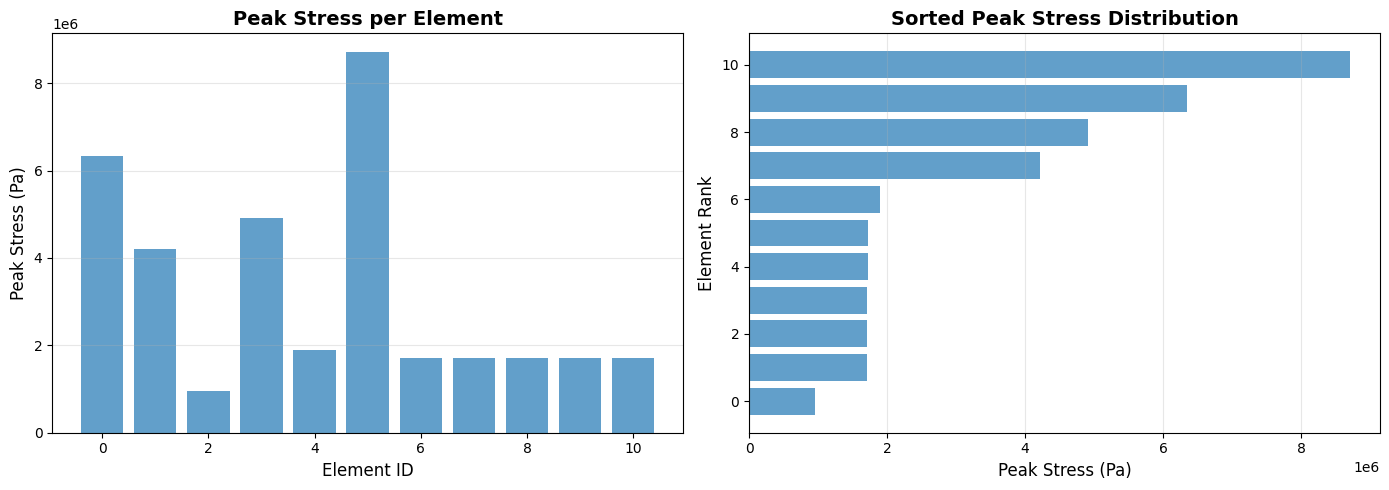

In [6]:
# 绘制峰值应力分布
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 柱状图
axes[0].bar(range(len(peak_stresses)), peak_stresses, alpha=0.7)
axes[0].set_xlabel('Element ID', fontsize=12)
axes[0].set_ylabel('Peak Stress (Pa)', fontsize=12)
axes[0].set_title('Peak Stress per Element', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# 排序后的峰值应力
sorted_indices = np.argsort(peak_stresses)
sorted_stresses = peak_stresses[sorted_indices]
axes[1].barh(range(len(sorted_stresses)), sorted_stresses, alpha=0.7)
axes[1].set_xlabel('Peak Stress (Pa)', fontsize=12)
axes[1].set_ylabel('Element Rank', fontsize=12)
axes[1].set_title('Sorted Peak Stress Distribution', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## 应力云图 (某一时刻)

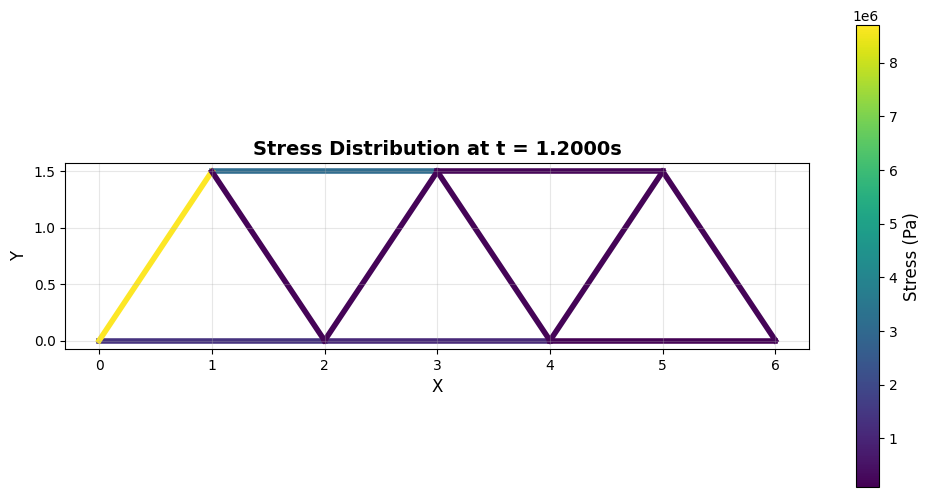

In [7]:
# 绘制某时刻的应力分布
from utils.data_loader import load_structure_config
from utils.config import STRUCTURE_PATH

# 加载结构配置
structure = load_structure_config(STRUCTURE_PATH)
nodes = {n['id']: n for n in structure['nodes']}
elements = {e['id']: e for e in structure['elements']}

# 选择峰值应力时刻
time_idx = int(max_stress_time / DT)
stress_at_peak = data['stress'][sample_idx, time_idx, :]

# 绘制应力分布
plot_stress_distribution(
    nodes, elements, stress_at_peak,
    title=f'Stress Distribution at t = {time_idx * DT:.4f}s'
)

## 多样本应力统计

In [8]:
# 对多个样本进行统计
n_samples = min(100, data['stress'].shape[0])
sample_indices = np.random.choice(data['stress'].shape[0], n_samples, replace=False)

all_peak_stresses = []
for idx in sample_indices:
    peak_stress = np.max(np.abs(data['stress'][idx]), axis=0)
    all_peak_stresses.append(peak_stress)

all_peak_stresses = np.array(all_peak_stresses)

print("=" * 50)
print("多样本峰值应力统计")
print("=" * 50)
print(f"样本数: {n_samples}")
print(f"平均峰值应力: {np.mean(all_peak_stresses):.4f} Pa")
print(f"最大峰值应力: {np.max(all_peak_stresses):.4f} Pa")
print(f"最小峰值应力: {np.min(all_peak_stresses):.4f} Pa")

多样本峰值应力统计
样本数: 100
平均峰值应力: 3040809.5641 Pa
最大峰值应力: 13498107.5918 Pa
最小峰值应力: 4268.8462 Pa
